# Arxiv coauthor network analysis

The focus of this notebook is to analysis of structural properties in co-authored networks using centrality measures. We'll be testing this out on papers in the condensed matter physics category.

### Load data and continue

Once the separate data prep script has been run at least once, we can simply load the file here to do the analysis.

In [1]:
import pandas as pd 
import numpy as np 

# import plotly.express as px
# import matplotlib.pyplot as plt
# import seaborn as sns
import networkx as nx
from networkx.algorithms.components.connected import connected_components

import pyvis
from pyvis.network import Network

from collections import Counter

data = pd.read_pickle('data/cond-mat-2021-2022.pkl')
data.head()

,id,title,category,abstract,version,doi,authors_parsed,num_authors,authors,DateTime,Day,Month,Year,author_pairs
2980,0707.2312,Integer partitions and exclusion statistics: L...,cond-mat.stat-mech math-ph math.CO math.MP,We compute the limit shapes of the Young dia...,"Fri, 14 Jan 2022 16:04:42 GMT",10.1088/1742-5468/2007/10/P10001,"[[Comtet, Alain, ], [Majumdar, Satya N., ], [O...",4,"[Comtet Alain, Majumdar Satya N., Ouvry Stepha...",2022-01-14 16:04:42+00:00,14,1,2022,"[(Comtet Alain, Majumdar Satya N.), (Comtet Al..."
6316,0711.0637,Symmetry breaking and quantum correlations in ...,cond-mat.mes-hall cond-mat.str-el nucl-th phys...,Investigations of emergent symmetry breaking...,"Wed, 22 Dec 2021 21:51:53 GMT",10.1088/0034-4885/70/12/R02,"[[Yannouleas, Constantine, ], [Landman, Uzi, ]]",2,"[Yannouleas Constantine, Landman Uzi]",2021-12-22 21:51:53+00:00,22,12,2021,"[(Yannouleas Constantine, Landman Uzi)]"
7807,0712.4280,Dynamics of emergent Cooper pairing at finite ...,cond-mat.supr-con cond-mat.mes-hall,We study the time evolution of a system of f...,"Sun, 18 Jul 2021 04:02:26 GMT",10.1103/PhysRevB.79.132504,"[[Yuzbashyan, Emil A., ], [Tsyplyatyev, Oleksa...",2,"[Yuzbashyan Emil A., Tsyplyatyev Oleksandr]",2021-07-18 04:02:26+00:00,18,7,2021,"[(Yuzbashyan Emil A., Tsyplyatyev Oleksandr)]"
13137,0806.3953,Short-distance thermal correlations in the XXZ...,cond-mat.str-el cond-mat.stat-mech hep-th,Recent studies have revealed much of the mat...,"Mon, 29 Nov 2021 15:11:59 GMT",10.1088/1742-5468/2008/08/P08010,"[[Boos, Herman E., ], [Damerau, Jens, ], [Göhm...",6,"[Boos Herman E., Damerau Jens, Göhmann Frank, ...",2021-11-29 15:11:59+00:00,29,11,2021,"[(Boos Herman E., Damerau Jens), (Boos Herman ..."
13434,0807.0487,Low-energy effective theory of the toric code ...,cond-mat.other hep-lat hep-th quant-ph,We determine analytically the phase diagram ...,"Wed, 3 Mar 2021 08:52:35 GMT",10.1103/PhysRevB.79.033109,"[[Vidal, J., ], [Dusuel, S., ], [Schmidt, K. P...",3,"[Vidal J., Dusuel S., Schmidt K. P.]",2021-03-03 08:52:35+00:00,3,3,2021,"[(Vidal J., Dusuel S.), (Vidal J., Schmidt K. ..."


In [2]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

astro_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
# astro_authors=pd.DataFrame(data['authors'].tolist()).rename(columns={0:'authors'})
astro_authors.head()

,authors
0,Comtet Alain
1,Majumdar Satya N.
2,Ouvry Stephane
3,Sabhapandit Sanjib
4,Yannouleas Constantine


In [3]:
papers_by_authors=astro_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(97878, 2)

In [4]:
papers_by_authors

,authors,Number of Papers Published
80907,Taniguchi Takashi,378
87637,Watanabe Kenji,377
21775,Felser Claudia,69
80904,Taniguchi T.,63
37366,Kalinin Sergei V.,61
...,...,...
40068,Kiselev Egor,1
40067,Kiselev Dmitry A.,1
40065,Kiselev Andrei,1
40063,Kiselev Alexander,1


In [5]:
# Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'authors'].tolist()
len(nodes_to_keep)

20574

# Generating the Edges of the Co-Author Network

Here we generate a graph of coauthors. Each node represents an author, and edges indicate that two authors have published a paper together.

In [6]:
authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Comtet Alain', 'Majumdar Satya N.', 1),
 ('Comtet Alain', 'Ouvry Stephane', 1),
 ('Comtet Alain', 'Sabhapandit Sanjib', 1),
 ('Majumdar Satya N.', 'Ouvry Stephane', 1),
 ('Majumdar Satya N.', 'Sabhapandit Sanjib', 3),
 ('Ouvry Stephane', 'Sabhapandit Sanjib', 1),
 ('Yannouleas Constantine', 'Landman Uzi', 6),
 ('Yuzbashyan Emil A.', 'Tsyplyatyev Oleksandr', 1),
 ('Boos Herman E.', 'Damerau Jens', 1),
 ('Boos Herman E.', 'Göhmann Frank', 1)]

In [7]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

96964


In [8]:
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

20506


382

In [9]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

20124

In [10]:
del G1, sub_g

In [11]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  20124
Number of Edges in AUthor Graph  155870


In [12]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)
        
        nodes_set.append(neighbours)
    # print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

## Subgraph visualization

To get an idea of what the network looks like, we'll select a small subgraph of the full coauthor network and visualize it.

In [57]:
# selected_coauthors = papers_by_authors['authors'].tolist()[2155:2157]
selected_coauthors = ['Goyal Abhay','Del Gado Emanuela']
print("Number of Selected CoAuthors ",len(selected_coauthors))
print(selected_coauthors)

print("Number of papers by selected coauthors: ")
for author in selected_coauthors:
    print(papers_by_authors[papers_by_authors['authors']==author]['Number of Papers Published'])

coauthor_nodes=getCoAuthorshipNetwork(G,selected_coauthors)
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

Number of Selected CoAuthors  2
['Goyal Abhay', 'Del Gado Emanuela']
Number of papers by selected coauthors: 
27107    5
Name: Number of Papers Published, dtype: int64
17056    9
Name: Number of Papers Published, dtype: int64
Number of CoAuthor Nodes  13
number of edges in the CoAuthor Subgraph  25


In [58]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

pyvis_nt.from_nx(coauthor_subgraph)

# pyvis_nt.show("output/Author18to20_CoAuthorGraph.html")
pyvis_nt.save_graph("output/GoyalDelGado_CoAuthorGraph.html")

# Network metrics: centrality

Centrality is a term used to describe the ranking of "importance" of nodes in networks. There are numerous ways to define/calculate centrality, each with their own interpretations. Below we calculate a few of these metrics for the coauthor network.

## Degree Centrality
The degtee of a node is the number oof other nodes to which it is connected
It is calculated by taking the degree of the node and dividing by n-1 where n is the number of nodes in G

In [13]:
degree_centrality = nx.degree_centrality(G)

In [14]:
# Top 10
counter = 0
for w in sorted(degree_centrality, key = degree_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 21:
        break
    print(w,"{:0.5f}".format(degree_centrality[w]))

Taniguchi Takashi 0.05372
Watanabe Kenji 0.05372
Felser Claudia 0.01471
Shi Youguo 0.01307
Yan Binghai 0.01128
Lei Hechang 0.01063
Taniguchi T. 0.01029
Yao Yugui 0.01019
Gu Genda 0.00934
Zhang Qinghua 0.00934
Hashimoto Makoto 0.00929
Dai Pengcheng 0.00909
Gu Lin 0.00894
Rotenberg Eli 0.00894
Yan Jiaqiang 0.00865
Moessner Roderich 0.00860
Wilson Stephen D. 0.00860
Jozwiak Chris 0.00845
Bostwick Aaron 0.00840
Lu Donghui 0.00805


## Closeness Centrality
Closeness centrality measures the mean distance from one node to any other node. The more central a node is, the closer it is to all the other nodes. The closeness of a node is typically referred to in its normalized form

In [15]:
closeness_centrality = nx.closeness_centrality(G)

In [16]:
# Top 10
counter = 0
for w in sorted(closeness_centrality, key = closeness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(closeness_centrality[w]))

Taniguchi Takashi 0.32711
Watanabe Kenji 0.32695
Felser Claudia 0.29256
Yan Binghai 0.28956
Lei Hechang 0.28596
Zhang Qi 0.27991
Wang Qi 0.27909
Rotenberg Eli 0.27807
Shi Youguo 0.27804
Jozwiak Chris 0.27794
Chen Yulin 0.27772
Bostwick Aaron 0.27758
Dai Pengcheng 0.27754
Ma Jie 0.27740
Zong Alfred 0.27740
Yazyev Oleg V. 0.27715
Yan Jiaqiang 0.27712
Wang Yao 0.27698
Chu Jiun-Haw 0.27677
Chang Tay-Rong 0.27645
Liu Yang 0.27624
Xu Xiaodong 0.27545


## Betweenness Centrality
It quantifies the number of times a node acts as a bridge along the shortest path between two other nodes
Vectices that have a high probability to occur on a randomly chosen shortest path between two randomly chosen verticles have a high betweenness

In [17]:
betweenness_centrality = nx.betweenness_centrality(G)

KeyboardInterrupt: 

In [36]:
# Top 10
counter = 0
for w in sorted(betweenness_centrality, key = betweenness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(betweenness_centrality[w]))

Krumholz Mark R. 0.02515
Loeb Abraham 0.02307
Zhang Bing 0.02126
Silk Joseph 0.02059
Li Hui 0.01982
Janka H. -T. 0.01803
Goriely S. 0.01780
Ireland Michael J. 0.01768
Siess L. 0.01733
Van Winckel H. 0.01544
Omukai Kazuyuki 0.01513
Sukhbold Tuguldur 0.01507
Ho Luis C. 0.01490
Ramirez-Ruiz Enrico 0.01477
Kasen Daniel 0.01445
Kuiper Rolf 0.01442
Vagnozzi Sunny 0.01423
Li Xiaolei 0.01407
Bujarrabal V. 0.01399
Yoshida Naoki 0.01392
Zhang Jun 0.01353
Metzger Brian D. 0.01351


## Eigenvector Centrality
A node is high in eigenvector centrality if it is connected to many other nodes who are themselves well connected.
Eigenvector centrality for each node is simply calculated as the proportional eigenvector values of the eigenvector with the largest eigenvector

In [37]:
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=500)

In [38]:
# Top 10
counter = 0
for w in sorted(eigenvector_centrality, key = eigenvector_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(eigenvector_centrality[w]))

Villaescusa-Navarro Francisco 0.20605
Spergel David N. 0.18685
Nishimichi Takahiro 0.13690
Ho Shirley 0.12665
Nelson Dylan 0.12613
Hernquist Lars 0.12550
Wandelt Benjamin D. 0.11510
Pillepich Annalisa 0.11269
Philcox Oliver H. E. 0.10183
Kamionkowski Marc 0.10146
Vogelsberger Mark 0.09474
Omukai Kazuyuki 0.09277
Loeb Abraham 0.09151
Yoshida Naoki 0.09060
Takada Masahiro 0.08989
Berti Emanuele 0.08979
Kocsis Bence 0.08401
Bernal José Luis 0.08200
Sherwin Blake D. 0.07992
Bose Sownak 0.07967
Kremer Kyle 0.07942
Hadzhiyska Boryana 0.07933


## PageRank

A variation of eigenvector centrality that uses Google's PageRank algorithm. Can be thought of as the probability of ending up at a page after randomly clicking on links.

In [ ]:
page_rank = nx.pagerank(G,max_iter=500)

In [ ]:
# Top 10
counter = 0
for w in sorted(page_rank, key = page_rank.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(eigenvector_centrality[w]))

# Coauthor network for individuals

Having calculated multiple measures of centrality, we can look at specific authors with high centrality and generate their coauthor graphs.

In [39]:
Silk_nodes = getCoAuthorshipNetwork(G,['Silk Joseph'])
Silk_network = nx.subgraph(G,Silk_nodes)
print("Number of Nodes in Silk Network ", len(Silk_network.nodes()))
print("Number of Edges in Silk Network ", len(Silk_network.edges()))

30
Number of Nodes in Silk Network  31
Number of Edges in Silk Network  61


In [40]:
Silk_nt=Network(notebook=True,height='800px', width='100%',heading='Silk Network')

print("Creating PyVis from NetworkX")
Silk_nt.from_nx(Silk_network)
Silk_nt.toggle_physics(True)
print("Saving PyVis Graph")

Silk_nt.show_buttons()
Silk_nt.show("Silk_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


In [41]:
data['is_SJ']=data['authors'].apply(lambda x:1 if "Silk Joseph" in x else 0)
SJ_papers=data[data['is_SJ']==1]
SJ_papers=SJ_papers.reset_index(drop=True)

print("Number of Papers by Silk Joseph on Arxiv is ",SJ_papers.shape[0])

Number of Papers by Silk Joseph on Arxiv is  33


In [42]:
print("The First Paper published by Silk Joseph was in ",min(SJ_papers['DateTime']))
print("The Recent Paper published by Silk Joseph was in  ",max(SJ_papers['DateTime']))

The First Paper published by Silk Joseph was in  2020-01-04 21:30:27+00:00
The Recent Paper published by Silk Joseph was in   2021-12-21 19:48:26+00:00


In [43]:
import nltk
from nltk.corpus import stopwords

In [44]:
def removeStopWords(text,stop_words):
    words=text.split()
    filtered_words=[word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [45]:
titles=SJ_papers['title'].tolist()
stop_words = set(stopwords.words('english')) 
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [46]:
def generateNGram(text,n=2):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    n_grams= ["_".join(ngram) for ngram in ngrams]
    n_grams=[ngram for ngram in n_grams if not ngram.startswith("_")]
    n_grams=[ngram for ngram in n_grams if not ngram.endswith("_")]
    return n_grams

def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [47]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Silk Joseph")

In [48]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Silk Joseph")

In [49]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning:

invalid escape sequence \d



In [50]:
def tokenise(sentences):
    return [gensim.utils.simple_preprocess(sentence, deacc=True,max_len=50) for sentence in sentences]

In [51]:
tokenised_sentences=tokenise(SJ_papers['title'].tolist())
tokenised_sentences[0]

['detectability',
 'of',
 'gravitational',
 'waves',
 'from',
 'the',
 'coalescence',
 'of',
 'massive',
 'primordial',
 'black',
 'holes',
 'with',
 'initial',
 'clustering']

In [52]:
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [53]:
def lemmatise(sentence,stop_words,allowed_postags=None):
    doc=nlp(sentence)
    #print(sentence)
    if allowed_postags!=None:
        tokens = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.text not in stop_words)]
    if allowed_postags==None:
        tokens= [token.lemma_ for token in doc if (token.text not in stop_words)]
    return tokens

In [54]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [55]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

['detectability',
 'gravitational',
 'wave',
 'coalescence',
 'massive',
 'primordial',
 'black',
 'hole',
 'initial',
 'clustering']

In [56]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2) 
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [57]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [58]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]] 

[('clustering', 1),
 ('coalescence', 1),
 ('detectability', 1),
 ('gravitational_wave', 1),
 ('initial', 1),
 ('massive', 1),
 ('primordial_black_hole', 1)]

In [59]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

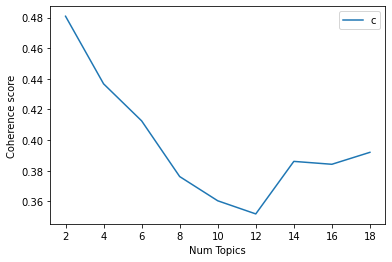

In [60]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"stochastic_gravitational" + 0.027*"wave_background" + '
  '0.020*"primordial_black_hole" + 0.019*"black_hole" + 0.015*"astrophysical" '
  '+ 0.015*"galaxy" + 0.015*"primordial" + 0.011*"binary" + 0.011*"neutron" + '
  '0.011*"burst"'),
 (1,
  '0.028*"gravitational_wave" + 0.025*"primordial_black_hole" + 0.019*"star" + '
  '0.018*"dark_matter" + 0.018*"merger" + 0.016*"binary" + 0.016*"impact" + '
  '0.016*"scale" + 0.012*"rate" + 0.012*"implication"')]


In [63]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.516405186348635

Coherence Score:  0.48082485689719523


In [64]:
def format_topics_sentences(texts,ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [65]:
df_topic_sents_keywords = format_topics_sentences(SJ_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta...",Detectability of Gravitational Waves from the ...
1,1,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta...",Evolution of primordial black hole spin due to...
2,2,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta...",Multi-messenger tests of gravity with weakly l...
3,3,1.0,0.9903,"gravitational_wave, primordial_black_hole, sta...",Probing the theory of gravity with gravitation...
4,4,1.0,0.9935,"gravitational_wave, primordial_black_hole, sta...",Cusp-to-core transition in low-mass dwarf gala...
5,5,0.0,0.9917,"stochastic_gravitational, wave_background, pri...",Embedding globular clusters in dark matter min...
6,6,1.0,0.9872,"gravitational_wave, primordial_black_hole, sta...",How to measure CMB spectral distortions with a...
7,7,0.0,0.9806,"stochastic_gravitational, wave_background, pri...",Time-dependence of the astrophysical stochasti...
8,8,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta...",Flattening of dark matter cusps during mergers...
9,9,0.0,0.9837,"stochastic_gravitational, wave_background, pri...",Subhalo sinking and off-center massive black h...


In [66]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

,Topic,Number of Documents,percentage_contribution
0,1.0,19,57.575758
1,0.0,14,42.424242


In [67]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [68]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

stochastic_gravitational 0.027
wave_background      0.027
primordial_black_hole 0.020
black_hole           0.019
astrophysical        0.015
galaxy               0.015
primordial           0.015
binary               0.011
neutron              0.011
burst                0.011
Topic 1 |---------------------

gravitational_wave   0.028
primordial_black_hole 0.025
star                 0.019
dark_matter          0.018
merger               0.018
binary               0.016
impact               0.016
scale                0.016
rate                 0.012
implication          0.012


In [69]:
# topic weights and dominant topics 
from sklearn.manifold import TSNE


# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 1.525622


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.136589
[t-SNE] KL divergence after 1000 iterations: 0.408525


In [70]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=SJ_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

,Text,tsne_x,tsne_y,Topic_No,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,Detectability of Gravitational Waves from the ...,164.306686,-206.650360,1,0,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta..."
1,Evolution of primordial black hole spin due to...,-231.828461,-219.951675,1,1,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta..."
2,Multi-messenger tests of gravity with weakly l...,64.619797,-210.705856,1,2,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta..."
3,Probing the theory of gravity with gravitation...,-46.924194,-237.377640,0,3,1.0,0.9903,"gravitational_wave, primordial_black_hole, sta..."
4,Cusp-to-core transition in low-mass dwarf gala...,252.036606,-248.688248,0,4,1.0,0.9935,"gravitational_wave, primordial_black_hole, sta..."


In [71]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])

In [72]:
Fabian_nodes = getCoAuthorshipNetwork(G,['Fabian A. C.'])
Fabian_network = nx.subgraph(G,Fabian_nodes)
print("Number of Nodes in Fabian Network ", len(Fabian_network.nodes()))
print("Number of Edges in Fabian Network ", len(Fabian_network.edges()))

4
Number of Nodes in Fabian Network  5
Number of Edges in Fabian Network  5


In [73]:
Fabian_nt=Network(notebook=True,height='800px', width='100%',heading='Fabian Network')

print("Creating PyVis from NetworkX")
Fabian_nt.from_nx(Fabian_network)
Fabian_nt.toggle_physics(True)
print("Saving PyVis Graph")

Fabian_nt.show_buttons()
Fabian_nt.show("Fabian_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


In [74]:
data['is_FA']=data['authors'].apply(lambda x:1 if "Fabian A. C." in x else 0)
FA_papers=data[data['is_FA']==1]
FA_papers=FA_papers.reset_index(drop=True)

print("Number of Papers by Fabian A. C. on Arxiv is ",FA_papers.shape[0])

Number of Papers by Fabian A. C. on Arxiv is  6


In [75]:
print("The First Paper published by Fabian A. C. was in ",min(FA_papers['DateTime']))
print("The Recent Paper published by Fabian A. C. was in  ",max(FA_papers['DateTime']))

The First Paper published by Fabian A. C. was in  2020-03-21 20:02:05+00:00
The Recent Paper published by Fabian A. C. was in   2021-06-07 14:40:54+00:00


In [76]:
titles=FA_papers['title'].tolist()
stop_words = set(stopwords.words('english')) 
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [77]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Fabian A.C.")

In [78]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Fabian A.C.")

In [79]:
tokenised_sentences=tokenise(FA_papers['title'].tolist())
tokenised_sentences[0]

['ray', 'observations', 'of', 'luminous', 'dusty', 'quasars', 'at']

In [80]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

['ray', 'observation', 'luminous', 'dusty', 'quasar']

In [81]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2) 
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [82]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [83]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]] 

[('dusty', 1), ('luminous', 1), ('observation', 1), ('quasar', 1), ('ray', 1)]

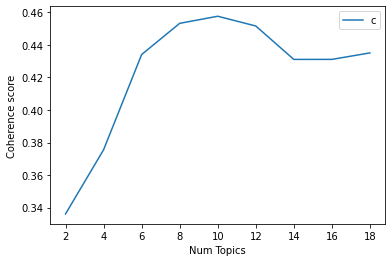

In [84]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [86]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.049*"cluster" + 0.049*"ray" + 0.049*"cold" + 0.049*"front" + 0.029*"black" + 0.029*"around" + 0.029*"hole" + 0.029*"venture" + 0.029*"plunge" + 0.029*"region"'), (1, '0.041*"observation" + 0.040*"hole" + 0.040*"around" + 0.040*"black" + 0.040*"radiation" + 0.040*"strong" + 0.040*"reverberation" + 0.040*"gravity" + 0.040*"accretion" + 0.040*"return"')]


In [87]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.162381958061208

Coherence Score:  0.33613797439710713


In [88]:
df_topic_sents_keywords = format_topics_sentences(FA_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9829,"cluster, ray, cold, front, black, around, hole...",X-ray Observations of Luminous Dusty Quasars a...
1,1,0.0,0.9920,"cluster, ray, cold, front, black, around, hole...",Venturing beyond the ISCO: Detecting X-ray emi...
2,2,0.0,0.9876,"cluster, ray, cold, front, black, around, hole...",Is there an enormous cold front at the virial ...
3,3,1.0,0.9847,"observation, hole, around, black, radiation, s...",Returning radiation in strong gravity around b...
4,4,1.0,0.9784,"observation, hole, around, black, radiation, s...",AGN-driven galactic outflows: comparing models...
5,5,0.0,0.9891,"cluster, ray, cold, front, black, around, hole...",The interaction between rising bubbles and col...


In [89]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

,Topic,Number of Documents,percentage_contribution
0,0.0,4,66.666667
1,1.0,2,33.333333


In [90]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

cluster              0.049
ray                  0.049
cold                 0.049
front                0.049
black                0.029
around               0.029
hole                 0.029
venture              0.029
plunge               0.029
region               0.029
Topic 1 |---------------------

observation          0.041
hole                 0.040
around               0.040
black                0.040
radiation            0.040
strong               0.040
reverberation        0.040
gravity              0.040
accretion            0.040
return               0.040


In [91]:
# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.888863
[t-SNE] KL divergence after 650 iterations: 0.203411


In [92]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=FA_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

,Text,tsne_x,tsne_y,Topic_No,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,X-ray Observations of Luminous Dusty Quasars a...,1480.554810,-41.775837,0,0,0.0,0.9829,"cluster, ray, cold, front, black, around, hole..."
1,Venturing beyond the ISCO: Detecting X-ray emi...,532.256348,80.125275,0,1,0.0,0.9920,"cluster, ray, cold, front, black, around, hole..."
2,Is there an enormous cold front at the virial ...,-249.562119,-1556.075317,0,2,0.0,0.9876,"cluster, ray, cold, front, black, around, hole..."
3,Returning radiation in strong gravity around b...,-501.156677,375.377319,1,3,1.0,0.9847,"observation, hole, around, black, radiation, s..."
4,AGN-driven galactic outflows: comparing models...,-48.942532,-624.956909,1,4,1.0,0.9784,"observation, hole, around, black, radiation, s..."


In [93]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])